In [2]:
from airflow_practice.config import settings
from pyspark.sql.session import SparkSession

datasource: 

https://www.ncei.noaa.gov/pub/data/uscrn/products/subhourly01/2020/


header: 
https://www.ncei.noaa.gov/pub/data/uscrn/products/subhourly01/headers.txt

In [3]:
# Generate a spark session
spark = SparkSession.builder.getOrCreate()
# Set the spark session time zone of the timestamp column to utc
spark.conf.set("spark.sql.session.timeZone", 'UTC')

24/12/19 19:07:25 WARN Utils: Your hostname, LinnoMacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.12 instead (on interface en0)
24/12/19 19:07:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/19 19:07:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/19 19:07:27 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


`rdd` stans for `Resilient Distributed Dataset`

In [4]:
# 指定したフォルダー配下の全てのファイルと読み込む
path = str(settings.data_path/".raw"/"*")
rdd = spark.sparkContext.textFile(path)


In [5]:
rdd.take(2)


['23583 20200101 0005 20191231 1505  2.514 -158.61   59.28   -17.5     0.0     30 0   -21.8 C 0    60 0 -99.000 -9999.0  1015 0   1.59 0',
 '23583 20200101 0010 20191231 1510  2.514 -158.61   59.28   -17.5     0.0     35 0   -22.1 C 0    60 0 -99.000 -9999.0  1015 0   1.35 0']

In [6]:
rdd.count()

210816

`map` stands for `MapReduce`


In [7]:
from datetime import datetime, timezone
from pyspark.sql import Row


In [8]:
def parse_line(line: str): 
    """A function to prase each singlge line read from the raw data."""

    f = line.split()
    # wbanno? 
    wbanno = f[0]

    # Generate data-time string, converting to utc time
    dt = datetime.strptime(f[1]+f[2], "%Y%m%d%H%M")
    dt = dt.replace(tzinfo=timezone.utc)
    
    # Replace the outlier of temperature (-9999.9)
    temperature  = None if f[8] == '-9999.0' else float(f[8])

    # Parse a string line into a Row object
    return Row(timestamp=dt,wbanno=wbanno, temperature=temperature )

In [10]:
# Use the map method to apply the parse line function on each line
# Get a series of Row objects
rows: list[Row] = rdd.map(parse_line)

In [11]:
rows.take(2)


[Row(timestamp=datetime.datetime(2020, 1, 1, 0, 5, tzinfo=datetime.timezone.utc), wbanno='23583', temperature=-17.5),
 Row(timestamp=datetime.datetime(2020, 1, 1, 0, 10, tzinfo=datetime.timezone.utc), wbanno='23583', temperature=-17.5)]

In [12]:
# Create df using rdd
df = rdd.map(parse_line).toDF()
df


DataFrame[timestamp: timestamp, wbanno: string, temperature: double]

In [13]:
# Show the upper 2 lines: 
df.show(2)


24/12/19 19:10:05 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 4 (TID 5): Attempting to kill Python Worker


+-------------------+------+-----------+
|          timestamp|wbanno|temperature|
+-------------------+------+-----------+
|2020-01-01 00:05:00| 23583|      -17.5|
|2020-01-01 00:10:00| 23583|      -17.5|
+-------------------+------+-----------+
only showing top 2 rows



In [14]:
# Show the aggressive information
df.describe().show()



+-------+-----------------+------------------+
|summary|           wbanno|       temperature|
+-------+-----------------+------------------+
|  count|           210816|            207720|
|   mean|          59994.0|2.7866825534372963|
| stddev|36411.08635760458| 9.831826313535235|
|    min|            23583|             -32.0|
|    max|            96405|              26.6|
+-------+-----------------+------------------+



Use SQL 

In [15]:
# Create a temp view
df.createOrReplaceTempView('uscrn')

In [16]:
# Use SQL query
query = '''
SELECT
  wbanno,
  min_by(timestamp, temperature) timestamp_min,
  min(temperature) t_min,
  max_by(timestamp, temperature) timestamp_max,
  max(temperature) t_max
FROM
  uscrn
GROUP by
  1
'''
spark.sql(query).show()

+------+-------------------+-----+-------------------+-----+
|wbanno|      timestamp_min|t_min|      timestamp_max|t_max|
+------+-------------------+-----+-------------------+-----+
| 23583|2020-02-01 16:15:00|-32.0|2020-08-17 00:20:00| 24.8|
| 96405|2020-01-10 17:30:00|-25.6|2020-07-03 22:55:00| 26.6|
+------+-------------------+-----+-------------------+-----+



save as `parquet` file

In [17]:
# Specify the saving path
saving_path = settings.data_path / "uscrn-parquet"

df.write.save(str(saving_path))


AnalysisException: [PATH_ALREADY_EXISTS] Path file:/Users/linpeihsuan/Documents/resume-repo/airflow-practice/data/uscrn-parquet already exists. Set mode as "overwrite" to overwrite the existing path.

In [28]:
for f in saving_path.glob("*"):
    print(f.name)
    


part-00000-7de80d23-620d-49ea-beda-9d8cae27cccc-c000.snappy.parquet
._SUCCESS.crc
part-00001-7de80d23-620d-49ea-beda-9d8cae27cccc-c000.snappy.parquet
.part-00000-7de80d23-620d-49ea-beda-9d8cae27cccc-c000.snappy.parquet.crc
_SUCCESS
.part-00001-7de80d23-620d-49ea-beda-9d8cae27cccc-c000.snappy.parquet.crc


Read the output files `parquet`

In [18]:
df2 = spark.read.load(str(saving_path))
df2.show(3)


+-------------------+------+-----------+
|          timestamp|wbanno|temperature|
+-------------------+------+-----------+
|2020-01-01 00:05:00| 96405|       NULL|
|2020-01-01 00:10:00| 96405|       NULL|
|2020-01-01 00:15:00| 96405|       NULL|
+-------------------+------+-----------+
only showing top 3 rows



In [19]:
df.groupBy("wbanno").avg("temperature").show()


+------+------------------+
|wbanno|  avg(temperature)|
+------+------------------+
| 23583|1.6492521732528165|
| 96405| 3.957719740493213|
+------+------------------+



output to `csv` file which is more easier for visualizing

In [20]:
df1 = df.where("timestamp>'2020-01-01' AND timestamp < '2020-04-01'")

In [23]:
df.show(5)

+-------------------+------+-----------+
|          timestamp|wbanno|temperature|
+-------------------+------+-----------+
|2020-01-01 00:05:00| 23583|      -17.5|
|2020-01-01 00:10:00| 23583|      -17.5|
|2020-01-01 00:15:00| 23583|      -17.6|
|2020-01-01 00:20:00| 23583|      -17.7|
|2020-01-01 00:25:00| 23583|      -17.6|
+-------------------+------+-----------+
only showing top 5 rows



24/12/19 19:11:08 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 17 (TID 18): Attempting to kill Python Worker


In [24]:
# output path
output_path = settings.data_path / ".export"

df1.coalesce(1).write.save(str(output_path), format='csv', header=True)

In [26]:
import matplotlib.pyplot as plt
import pandas as pd


In [28]:
dataset = pd.read_csv(output_path/"part-00000-094d4565-f573-430c-8fcd-374413e94f62-c000.csv")

In [38]:
dataset_1 = dataset.loc[dataset["wbanno"] == 96405 , ["timestamp", "temperature"]]

In [41]:
timestamp = dataset["timestamp"].values
temperature =dataset['temperature'].values

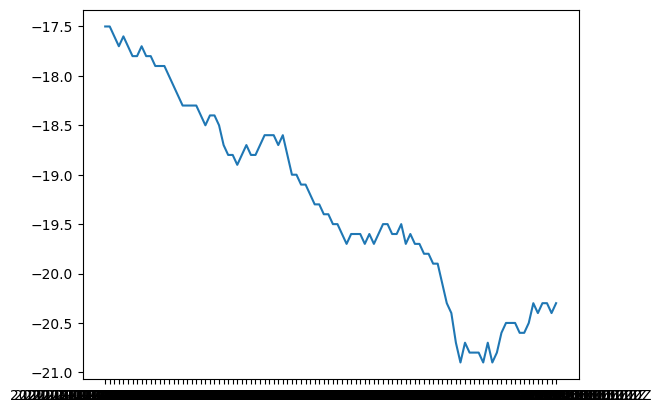

In [43]:
plt.plot(timestamp[:100 ], temperature[:100])